# **Set Up**

In [ ]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import os

import datetime

from tensorflow import keras 
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint 
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding

print("Keras version " + keras.__version__)
print("Tensorflow version " + tf.__version__)

Keras version 2.4.0
Tensorflow version 2.4.1


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# **Data Loading and Preprocessing**

In [ ]:
base_path = '/content/drive/My Drive/DATA2040_Final_Project_YARD'

In [ ]:
ratings = pd.read_csv(base_path + '/data/ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

In [ ]:
ratings

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
...,...,...,...,...,...
1000204,6040,1091,1,6039,1090
1000205,6040,1094,5,6039,1093
1000206,6040,562,5,6039,561
1000207,6040,1096,4,6039,1095


In [ ]:
max_userid = ratings['user_id'].drop_duplicates().max()
max_movieid = ratings['movie_id'].drop_duplicates().max()
print(max_userid)
print(max_movieid)

6040
3952


In [ ]:
users = pd.read_csv(base_path + '/data/users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

In [ ]:
users

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer
...,...,...,...,...,...
6035,6036,F,32603,25-34,scientist
6036,6037,F,76006,45-49,academic/educator
6037,6038,F,14706,56+,academic/educator
6038,6039,F,01060,45-49,other or not specified


In [ ]:
movies = pd.read_csv(base_path + '/data/movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [ ]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [ ]:
# Create training set
RNG_SEED = 32
shuffled_ratings = ratings.sample(frac=1., random_state=RNG_SEED)

# Shuffling users
Users = shuffled_ratings['user_emb_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_emb_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [3620 2624 1259 ... 3945 2164   80] , shape = (1000209,)
Movies: [3571 1993 3504 ... 2139 3267  110] , shape = (1000209,)
Ratings: [1 3 4 ... 4 3 5] , shape = (1000209,)


# **Exploratory Data Analysis**

**MOVIES**

In [ ]:
# get movie shape
movies.shape

(3883, 3)

There are 3883 movies in the dataset. The first column contains the movie ID (integers), the second column contains the movie titles (along with the year it was released), and the third column contains the movie genres. 

In [ ]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies.describe()

,movie_id
count,3883.000000
mean,1986.049446
std,1146.778349
min,1.000000
25%,982.500000
50%,2010.000000
75%,2980.500000
max,3952.000000


In [ ]:
# check for missing values
movies.isnull().sum(axis=0)

movie_id    0
title       0
genres      0
dtype: int64

In [ ]:
# check count of different genres
movies['genres'].value_counts()

Drama                         843
Comedy                        521
Horror                        178
Comedy|Drama                  162
Comedy|Romance                142
                             ... 
Sci-Fi|War                      1
Action|Comedy|Sci-Fi|War        1
Drama|Horror|Thriller           1
Film-Noir|Romance|Thriller      1
Children's|Fantasy|Sci-Fi       1
Name: genres, Length: 301, dtype: int64

In [ ]:
# check number of unique genres
movies['genres'].value_counts().nunique()

47

In [ ]:
# merge movies and ratings
movies_ratings = pd.merge(movies, ratings)

In [ ]:
movies_ratings.head()

,movie_id,title,genres,user_id,rating,user_emb_id,movie_emb_id
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,0,0
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,5,0
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,7,0
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,8,0
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,9,0


In [ ]:
top10 = movies_ratings.groupby('title').size().sort_values(ascending=False)[:10]
top10

title
American Beauty (1999)                                   3428
Star Wars: Episode IV - A New Hope (1977)                2991
Star Wars: Episode V - The Empire Strikes Back (1980)    2990
Star Wars: Episode VI - Return of the Jedi (1983)        2883
Jurassic Park (1993)                                     2672
Saving Private Ryan (1998)                               2653
Terminator 2: Judgment Day (1991)                        2649
Matrix, The (1999)                                       2590
Back to the Future (1985)                                2583
Silence of the Lambs, The (1991)                         2578
dtype: int64

<function matplotlib.pyplot.show>

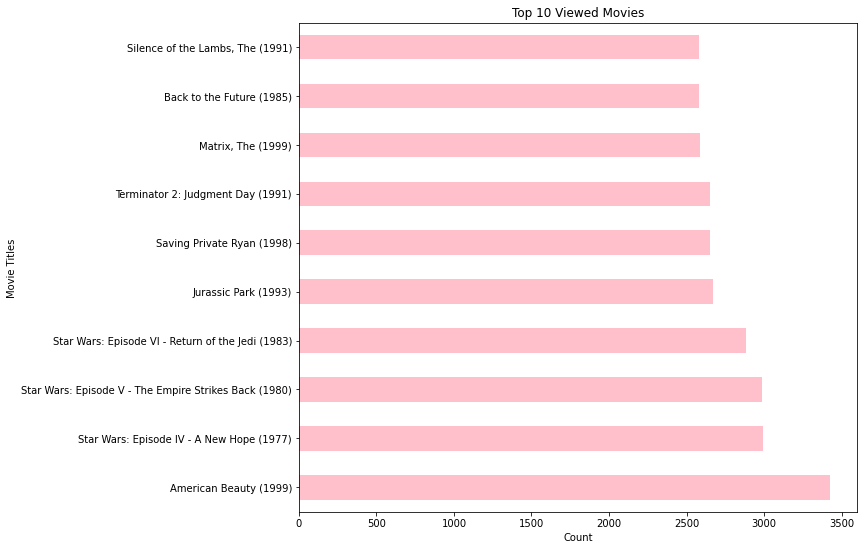

In [ ]:
#Plot Top 10 Movies Viewed
movies_ratings.groupby('title')['user_id'].count().sort_values(ascending = False)[:10].plot(kind ='barh', figsize = (10,9), color= "pink")
plt.xlabel('Count')
plt.ylabel('Movie Titles')
plt.title('Top 10 Viewed Movies')
plt.savefig(base_path + '/figures/plt/' + 'Bar chart Top 10 Movies Viewed.jpg',bbox_inches='tight')
plt.show

The graph shows the top 10 movies viewed (each user can only be counted once) by count. American Beauty is the highest followed by the 3 Star Wars Movies.

In [ ]:
#counts unique genres
n = len(pd.unique(movies_ratings ['genres']))
print("No.of.unique values :", n)

No.of.unique values : 301


In [ ]:
#define a function that counts the number of times each genre appear:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in movies_ratings[ref_col].str.split('|'):
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue
        for s in liste_keywords: 
            if pd.notnull(s): keyword_count[s] += 1
    # convert the dictionary in a list to sort the keywords  by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [ ]:
genre_labels = set()
for s in movies_ratings['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

In [ ]:
keyword_occurences, dum = count_word(movies_ratings, 'genres', genre_labels)
#keyword_occurences
trunc_occurences = keyword_occurences[0:50]
trunc_occurences

[['Comedy', 356580],
 ['Drama', 354529],
 ['Action', 257457],
 ['Thriller', 189680],
 ['Sci-Fi', 157294],
 ['Romance', 147523],
 ['Adventure', 133953],
 ['Crime', 79541],
 ['Horror', 76386],
 ["Children's", 72186],
 ['War', 68527],
 ['Animation', 43293],
 ['Musical', 41533],
 ['Mystery', 40178],
 ['Fantasy', 36301],
 ['Western', 20683],
 ['Film-Noir', 18261],
 ['Documentary', 7910]]

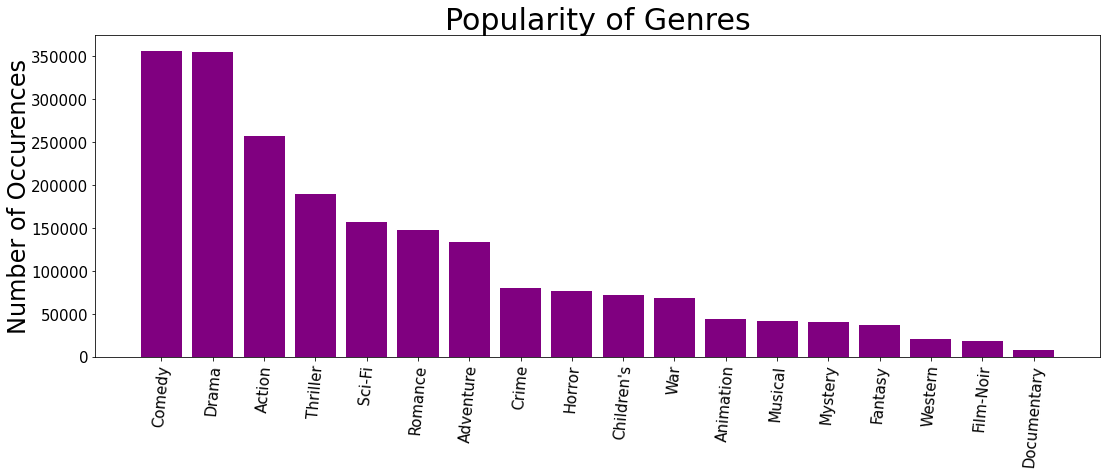

In [ ]:
# Bar graph of popularity of genres
fig = plt.figure(1, figsize=(18,13))
ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Number of Occurences", fontsize = 24, labelpad = 0)
ax2.bar(x_axis, y_axis, align = 'center', color = 'purple')
plt.title("Popularity of Genres",fontsize = 30)
plt.savefig(base_path + '/figures/plt/' + 'Bar graph popularity of genres.jpg',bbox_inches='tight')
plt.show()

The bar graph shows the number of occurences for each genre(genre was edited because there were too many genres). Some movies had multiple genres (ex. romantic comedy woud count as romance and comedy) We can see that comedy and drama are the most present genres. 

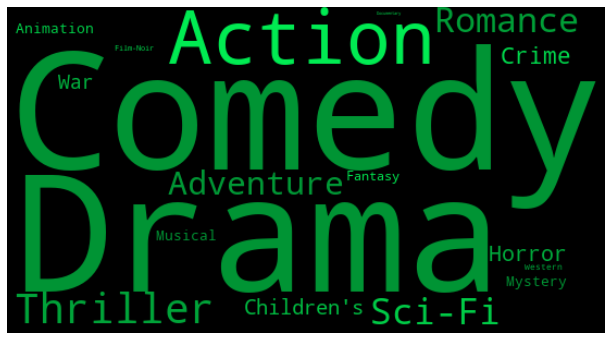

In [ ]:
#Wordcloud visualization of popularity of genres
# Function that control the color of the words
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = keyword_occurences[0:50]
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.savefig(base_path + '/figures/plt/' + 'Wordcloud visualization of popularity of genres.jpg',bbox_inches='tight')
plt.show()

This Wordcloud visualization of popularity of genres shows the same things as the bar grah above which is the number of occurences for each genre(genre was edited because there were too many genres). Some movies had multiple genres (ex. romantic comedy woud count as romance and comedy) Again, we can see that comedy and drama are the most present genres.

**RATINGS**

In [ ]:
ratings.describe()

,user_id,movie_id,rating,user_emb_id,movie_emb_id
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,3.023512e+03,1.864540e+03
std,1.728413e+03,1.096041e+03,1.117102e+00,1.728413e+03,1.096041e+03
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,1.505000e+03,1.029000e+03
50%,3.070000e+03,1.835000e+03,4.000000e+00,3.069000e+03,1.834000e+03
75%,4.476000e+03,2.770000e+03,4.000000e+00,4.475000e+03,2.769000e+03
max,6.040000e+03,3.952000e+03,5.000000e+00,6.039000e+03,3.951000e+03


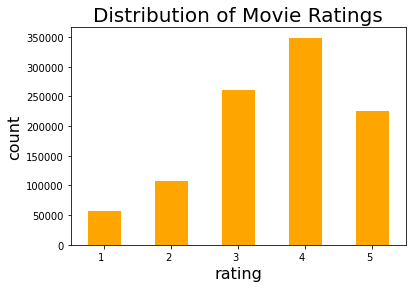

In [ ]:
# plot a bar chart of ratings count
ratings.value_counts(ratings['rating']).sort_index().plot.bar(color=["orange"])
plt.title('Distribution of Movie Ratings', fontsize=20)
plt.ylabel('count', fontsize=16)
plt.xlabel(ratings['rating'].name, fontsize=16)
plt.xticks(rotation=0, ha='right')
plt.savefig(base_path + '/figures/plt/' + 'Bar chart ratings count.jpg',bbox_inches='tight')
plt.show()

In [ ]:
# mean ratings
np.mean(ratings['rating'])

3.581564453029317

The bar plot shows the distribution of movie ratings. The mode (i.e. most common) rate is 4, and the distribution is left-skewed. The mean rating is 3.58.

<function matplotlib.pyplot.show>

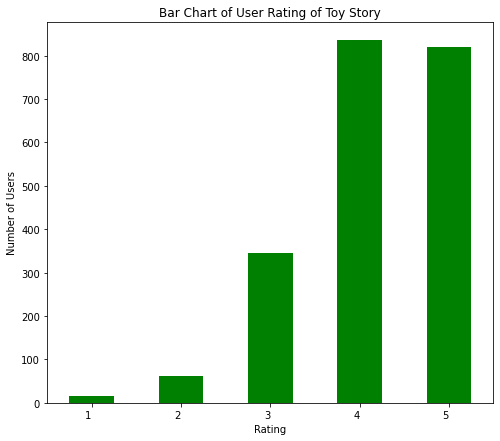

In [ ]:
#Visualize the User Rating of the Movie “Toy Story”
movies_ratings[movies_ratings.title == 'Toy Story (1995)'].groupby('rating')['user_id'].count().plot(kind = 'bar', color = 'green',figsize = (8,7))
plt.xlabel('Rating')
plt.ylabel('Number of Users')
plt.title('Bar Chart of User Rating of Toy Story')
plt.xticks(rotation=0, ha='right')
plt.savefig(base_path + '/figures/plt/' + 'Bar chart User Rating of the Movie “Toy Story”.jpg',bbox_inches='tight')
plt.show

The bar plot shows the distribution of movie ratings for Toy Story by user. Clearly, we can see that Toy Story has received very good reviews give that it has mostly 4 and 5 stars

**USERS**

**Gender**

In [ ]:
# get gender count
users['gender'].value_counts()

M    4331
F    1709
Name: gender, dtype: int64

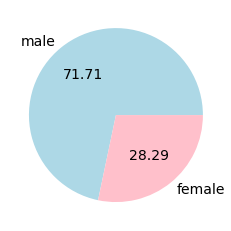

In [ ]:
# plot a pie chart of gender distribution
gender_data = users.value_counts(users['gender'])
plt.pie(gender_data, labels = ["male", "female"], autopct='%.2f', colors=["lightblue", "pink"], textprops={'fontsize': 14})
plt.savefig(base_path + '/figures/plt/' + 'Pie chart of gender distribution.jpg',bbox_inches='tight')
plt.show()

From the pie chart, 71.7% of the users are male, and 28.3% are female. Thus, the data is imbalanced towards male users.

**Age range**

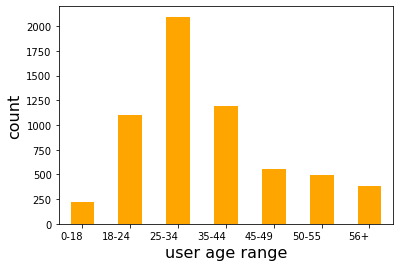

In [ ]:
# replace below 18 values with 0-18, for plot order
users['age_desc'] = users['age_desc'].replace('Under 18', '0-18')
users.head()

# plot a bar chart of user age ranges
users.value_counts(users['age_desc']).sort_index().plot.bar(color=["orange"])
plt.ylabel('count', fontsize=16)
plt.xlabel('user age range', fontsize=16)
plt.xticks(rotation=0, ha='right')
plt.savefig(base_path + '/figures/plt/' + 'Bar chart of user age ranges.jpg',bbox_inches='tight')
plt.show()

From the bar plot of user age ranges, the age distribution has its mode at 25-34, and appears to have a right skew. Overall, most users appear to be young adults between 18-44.

In [ ]:
users.value_counts(users['age_desc'])

age_desc
25-34    2096
35-44    1193
18-24    1103
45-49     550
50-55     496
56+       380
0-18      222
dtype: int64

In [ ]:
age_ranges = users['age_desc'].unique()

**Occupation**

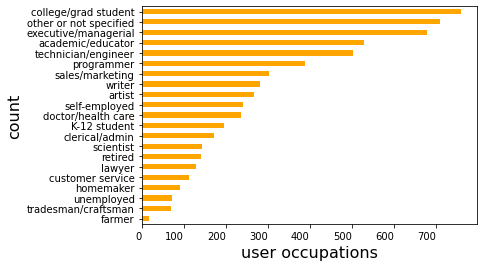

In [ ]:
# get list of occupations
users.value_counts(users['occ_desc']).nunique()

# plot a sorted horizontal bar chart of user occupations
users.value_counts(users['occ_desc']).sort_values(ascending=True).plot.barh(color=["orange"])
plt.ylabel('count', fontsize=16)
plt.xlabel('user occupations', fontsize=16)
plt.xticks(rotation=0, ha='right')
plt.savefig(base_path + '/figures/plt/' + 'Sorted horizontal bar chart of user occupations.jpg',bbox_inches='tight')
plt.show()

There are 21 different occupations in the dataset. The most common occupation in the Movie Lens user data is college/grad student, followed by 'other, and then 'executive managerial'. The top 5 most common occuaptions also include academic/educator, and technician engineering. Thus, users appear to be relatively highly educated.